In [1]:
# Start ferret
import pyferret
import numpy as np
pyferret.start(quiet=True)


True

In [2]:
# Load the data set and store as a Python variable
# Python dictionaries are a type of variable that
# stores the data along with its metadata.
(error_value, error_message) = pyferret.run('use /home/jovyan/data/1_mesh_mask_xyd.nc')
glamt_dict = pyferret.getdata('glamt',False)
gphit_dict = pyferret.getdata('gphit',False)

# The "keys" are the names of the entries in the
# dictionary - its pieces.
glamt_dict.keys()

dict_keys(['title', 'data', 'missing_value', 'data_unit', 'axis_types', 'axis_names', 'axis_units', 'axis_coords'])

In [3]:
# Get data directly from the dictionary object (which
# includes metadata) and squeeze out unnecessary
# index places.
glamt = np.squeeze(glamt_dict['data'])
gphit = np.squeeze(gphit_dict['data'])

# Get the sizes of the arrays.
imt,jmt = np.shape(glamt)

imt,jmt

(1784, 1719)

In [4]:
# Need to rotate the array to plot North upward
# Experiments with this suggest that it doesn't
# as I initially expected.
# Need to do more experiments.
#glamt = np.reshape(glamt,(jmt,-1), order='C')
#gphit = np.reshape(gphit,(jmt,-1), order='C')


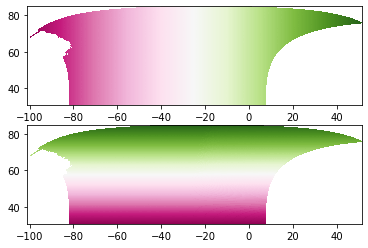

In [5]:
# Make a plot to verify that data have been loaded
# Using pcolormesh is good because it explicitly
# requires the pixel locations rather than implicit
# pixel locations with an image plotting tool.
import matplotlib.pyplot as plt
cmap = plt.get_cmap('PiYG')
fig, (ax0,ax1) = plt.subplots(nrows=2)
im = ax0.pcolormesh(glamt[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2],glamt[1:imt-2,1:jmt-2], cmap=cmap)
im = ax1.pcolormesh(glamt[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2],gphit[1:imt-2,1:jmt-2], cmap=cmap)
plt.show()


# To do:

1. load grids
2. load grid spacings
3. load SSH
4. figure out downscaling
5. element-by-element mult spacings by area
6. find average and store
